In [1]:
import copy

from IPython.core.pylabtools import figsize
%cd ..
%load_ext autoreload
%autoreload 2

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import json
import pandas as pd
from mol_gen_docking.data.pdb_uniprot.target_naming import fetch_uniprot_id_from_pdbid
from tqdm import tqdm
from multiprocessing import Pool
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem

FIG_PATH = "../-Philippe-MolGenDocking/Figures/reaction_data"
os.makedirs(FIG_PATH, exist_ok=True)
tqdm.pandas()

# Prompts

In [3]:
from mol_gen_docking.data.pydantic_dataset import read_jsonl
from pathlib import Path

def load(path:str):
    data = read_jsonl(Path(path))
    return [line.conversations[0].meta for line in data]

def get_n_reactions_steps(row: pd.Series):
    if not row["type of objective"] in ["full synthesis", "product prediction"]:
        return row["idx_chosen"] + 1
    else:
        return len(row["full_reaction"].split("\n"))

def runtime_get_reactants(row: pd.Series):
    full_reaction = row["full_reaction"]
    reac_steps = full_reaction.split("\n")
    reactants = [
        reac.split(" -> ")[0].split(" + ") for reac in reac_steps
    ]
    return reactants

def runtime_get_products(row: pd.Series):
    full_reaction = row["full_reaction"]
    reac_steps = full_reaction.split("\n")
    products = [
        reac.split(" -> ")[1].split(" + ")[0] for reac in reac_steps
    ]
    return products

def smarts_to_image(smarts):
    rxn = AllChem.ReactionFromSmarts(smarts)
    rxn.Initialize()
    img = AllChem.Draw.ReactionToImage(rxn, subImgSize=(300,300))
    return img


def get_df(data_d):
    df = pd.DataFrame(data_d)
    df= df.explode(["properties", "objectives"]).reset_index(drop=True)
    df["last molecule passes filter"] = df.pass_filters.apply(lambda x: x[-1])
    df["prop. of molecules passing filter"] = df.pass_filters.apply(lambda x: np.mean(x))

    df["type of objective"]  = df.objectives.apply(
        lambda x: "full synthesis" if "full_path" in x else "reactant prediction" if "reactant" in x else "product prediction" if "products" in x else "product prediction" if "product" in x else x
    )
    df["reaction_steps"] = pd.Categorical(
        df.apply(
           get_n_reactions_steps, axis=1
        ), ordered=True
    )

    df["all_reactants"] = df.apply(runtime_get_reactants, axis = 1)
    df["all_products"] = df.apply(runtime_get_products, axis = 1)
    return df

df_zinc = pd.read_csv("data/properties.csv")

df_zinc.rename(columns={
    "QED":"qed",
    "CalcExactMolWt":"ExactMolWt",
    "CalcTPSA":"TPSA",
    "CalcNumHBA":"NumHAcceptors",
    "CalcNumHBD":"NumHDonors",
    "CalcNumRotatableBonds":"NumRotatableBonds",
    "CalcNumAromaticRings":"NumAromaticRings",
    "CalcHallKierAlpha":"HallKierAlpha",
}, inplace=True)

df = get_df(load("data/synthesis/train_prompts.jsonl"))
df

,properties,objectives,target,prompt_id,full_reaction,or_smarts,impossible,smarts,reactants,products,building_blocks,idx_chosen,n_building_blocks,pass_filters,last molecule passes filter,prop. of molecules passing filter,type of objective,reaction_steps,all_reactants,all_products
0,smarts,smarts,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",synth0,O=C(CCC(F)F)c1ccccc1 + C#CCNC(=O)c1ccccn1 -> C...,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",True,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...","[[Cn1cc(Br)c(S(=O)(=O)Cl)n1, CCOC(=O)c1c(NC(=O...",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1],[],0,0,[True],True,1.0,smarts,1,"[[O=C(CCC(F)F)c1ccccc1, C#CCNC(=O)c1ccccn1]]",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1]
1,full_path,full_path,[C#CCN1C(=O)CCN=C1NCC1(CC(=O)N2CC(=CC)C2)CCCc2...,synth1,C#CCNC(=O)CCN + NCC1(CC(=O)O)CCCc2ccccc21 -> C...,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...",False,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...","[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C..."
2,final_product,final_product,[O=C1c2occc2S(=O)(=O)N1CCCO],synth2,NCCCO + COC(=O)c1occc1S(=O)(=O)Cl -> O=C1c2occ...,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,False,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO],[],0,0,[True],True,1.0,product prediction,1,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO]
3,all_reactants_bb_ref,all_reactants_bb_ref,"[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br]",synth3,CSCCN(CC(=O)O)CC(=O)O + Cc1ccc(N)c(N)c1Br -> C...,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...",False,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...","[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC...","[C#CCC(C)(C)C, C=CCc1ccc(OCc2ccc(C(=O)O)o2)c(O...",0,10,"[True, True]",True,1.0,reactant prediction,1,"[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC..."
4,full_path,full_path,[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)C#CCC2CCCCC2)cnn1C],synth4,Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C -> Cc1c(C(...,"[[OH,O-][C$(C(=O)([OH,O-])([CX4])),C$([CH](=O)...",False,"[[C$(C(C)([CX4])([CX4])([CX4])),C$([CH](C)([CX...","[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,full_path_bb_ref,full_path_bb_ref,[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(C(O)...,synth49995,NCc1ccc(C(F)(F)F)c(Cl)c1 + Cc1ccc(C[C@@H](N)CC...,"[[C;!$(C=[N,O,S]):1][NH2:2].[NH2:3][C;!$(C=[O,...",True,"[[#6:1][C;H1,$([C]([#6])[#6]):2]=[OD1:3].[Cl,B...","[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...,"[C1COC(CC2CC2)CN1, CC(=O)/C=C/Cl, CC1(CN)Cc2cc...",0,11,"[True, True]",True,1.0,full synthesis,2,"[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...
49996,full_path_smarts_ref,full_path_smarts_ref,[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,synth49996,O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1 + CC(C)n1cnnc1...,"[[#6;!$(C=[S,O,N]):1][Cl,$(OS(=O)(=O)[#6;!R])]...",False,"[[#6:1][N:2]=[C:3]=[S:4].[NX3;!$(N[C]=[S,O,N])...","[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,[],0,0,[True],True,1.0,full synthesis,1,"[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...
49997,smarts,smarts,"[[NX3;!$(N[C,S]=[S,O,N]);$(N[#6]);!$(N[#7]);H1...",synth49997,c1c(C2CC2)nn2c1CNCC2 + COc1noc(CO)c1Br -> COc1...,"[[NX3

In [4]:
df

,properties,objectives,target,prompt_id,full_reaction,or_smarts,impossible,smarts,reactants,products,building_blocks,idx_chosen,n_building_blocks,pass_filters,last molecule passes filter,prop. of molecules passing filter,type of objective,reaction_steps,all_reactants,all_products
0,smarts,smarts,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",synth0,O=C(CCC(F)F)c1ccccc1 + C#CCNC(=O)c1ccccn1 -> C...,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",True,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...","[[Cn1cc(Br)c(S(=O)(=O)Cl)n1, CCOC(=O)c1c(NC(=O...",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1],[],0,0,[True],True,1.0,smarts,1,"[[O=C(CCC(F)F)c1ccccc1, C#CCNC(=O)c1ccccn1]]",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1]
1,full_path,full_path,[C#CCN1C(=O)CCN=C1NCC1(CC(=O)N2CC(=CC)C2)CCCc2...,synth1,C#CCNC(=O)CCN + NCC1(CC(=O)O)CCCc2ccccc21 -> C...,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...",False,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...","[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C..."
2,final_product,final_product,[O=C1c2occc2S(=O)(=O)N1CCCO],synth2,NCCCO + COC(=O)c1occc1S(=O)(=O)Cl -> O=C1c2occ...,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,False,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO],[],0,0,[True],True,1.0,product prediction,1,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO]
3,all_reactants_bb_ref,all_reactants_bb_ref,"[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br]",synth3,CSCCN(CC(=O)O)CC(=O)O + Cc1ccc(N)c(N)c1Br -> C...,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...",False,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...","[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC...","[C#CCC(C)(C)C, C=CCc1ccc(OCc2ccc(C(=O)O)o2)c(O...",0,10,"[True, True]",True,1.0,reactant prediction,1,"[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC..."
4,full_path,full_path,[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)C#CCC2CCCCC2)cnn1C],synth4,Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C -> Cc1c(C(...,"[[OH,O-][C$(C(=O)([OH,O-])([CX4])),C$([CH](=O)...",False,"[[C$(C(C)([CX4])([CX4])([CX4])),C$([CH](C)([CX...","[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,full_path_bb_ref,full_path_bb_ref,[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(C(O)...,synth49995,NCc1ccc(C(F)(F)F)c(Cl)c1 + Cc1ccc(C[C@@H](N)CC...,"[[C;!$(C=[N,O,S]):1][NH2:2].[NH2:3][C;!$(C=[O,...",True,"[[#6:1][C;H1,$([C]([#6])[#6]):2]=[OD1:3].[Cl,B...","[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...,"[C1COC(CC2CC2)CN1, CC(=O)/C=C/Cl, CC1(CN)Cc2cc...",0,11,"[True, True]",True,1.0,full synthesis,2,"[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...
49996,full_path_smarts_ref,full_path_smarts_ref,[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,synth49996,O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1 + CC(C)n1cnnc1...,"[[#6;!$(C=[S,O,N]):1][Cl,$(OS(=O)(=O)[#6;!R])]...",False,"[[#6:1][N:2]=[C:3]=[S:4].[NX3;!$(N[C]=[S,O,N])...","[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,[],0,0,[True],True,1.0,full synthesis,1,"[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...
49997,smarts,smarts,"[[NX3;!$(N[C,S]=[S,O,N]);$(N[#6]);!$(N[#7]);H1...",synth49997,c1c(C2CC2)nn2c1CNCC2 + COc1noc(CO)c1Br -> COc1...,"[[NX3

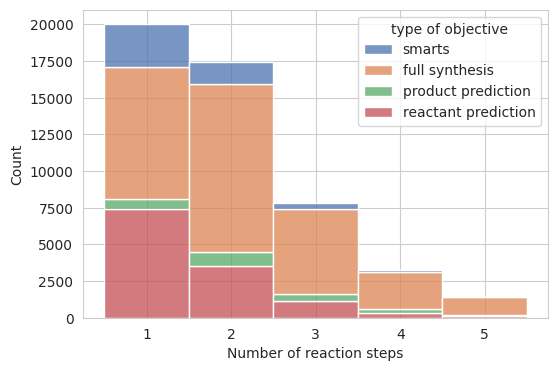

In [5]:
fig,ax = plt.subplots(figsize=(6,4))

sns.histplot(df, x="reaction_steps", hue="type of objective", multiple="stack", palette="deep",ax=ax)
ax.set_xlabel("Number of reaction steps")
ax.set_ylabel("Count")
fig.savefig(os.path.join(FIG_PATH,"reaction_steps_histogram.pdf"), bbox_inches='tight')

In [9]:
def plot_descriptor_distributions(df_descriptors, df_zinc):
    fig, axes = plt.subplots(2,4, figsize=(12,5))
    axes = axes.flatten()

    for i,col in enumerate(
        [
            "qed",
            "ExactMolWt",
            "TPSA",
            "NumHAcceptors",
            "NumHDonors",
            "NumRotatableBonds",
            "NumAromaticRings",
            "HallKierAlpha",
        ]
    ):
        sns.kdeplot(df_zinc, x=col, ax=axes[i], color="black",label="ZINC")
        sns.histplot(
            df_descriptors,
            x=col,
            hue=df["reaction_steps"],
            ax=axes[i],
            palette="viridis",
            stat="density",
            multiple="stack",
            legend=i == len(axes)-1,
            bins= 10
        )

        axes[i].set_title(col)

    fig.tight_layout()

In [ ]:
from rdkit.Chem import Descriptors
from rdkit import Chem

def get_desc(smi):
    mol = Chem.MolFromSmiles(smi)
    descriptors =  Descriptors.CalcMolDescriptors(mol)
    return descriptors

from multiprocessing import Pool



with Pool(32) as p:
    descs = list(tqdm(p.imap(get_desc, [x[-1] for x in df["products"]]), total=len(df)))

df_descriptors = pd.DataFrame(descs)

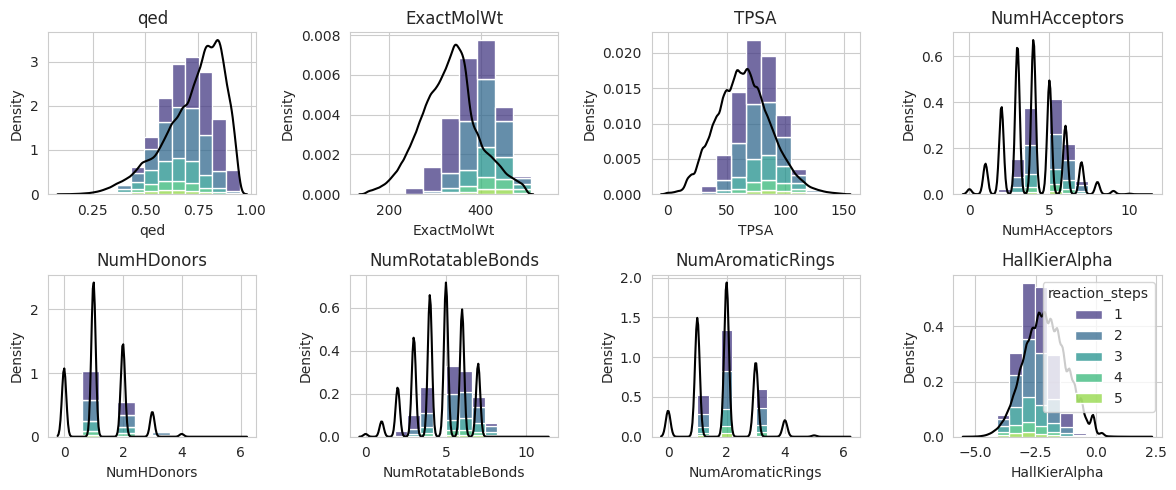

In [10]:
plot_descriptor_distributions(df_descriptors, df_zinc)

In [11]:
df_per_step = df[["all_products", "all_reactants", "or_smarts", "pass_filters", "impossible"]].rename(
    columns={
        "all_reactants": "reactants",
        "all_products": "products",
    }
)
df_per_step["n_step"] =df_per_step.products.apply(lambda x: list(range(1,1+len(x))))
df_per_step = df_per_step.explode(["reactants","products", "or_smarts", "pass_filters", "n_step"])
df_per_step["n_reactants"] = pd.Categorical(df_per_step.reactants.apply(len), ordered=True)
df_per_step

,products,reactants,or_smarts,pass_filters,impossible,n_step,n_reactants
0,C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1,"[O=C(CCC(F)F)c1ccccc1, C#CCNC(=O)c1ccccn1]","[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6:...",True,True,1,2
1,C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21,"[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21]","([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH2...",True,False,1,2
1,C#CCN1C(=O)CCN=C1NCC1(CC(=O)N2CC(=CC)C2)CCCc2c...,"[CC=C1CNC1, C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc...","[NX3;!$(N[C]=[S,O,N]);$(N[#6,S]);!$(N[#7]);H1,...",True,False,2,2
2,O=C1c2occc2S(=O)(=O)N1CCCO,"[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]",[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:7...,True,False,1,2
3,CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1,"[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br]","[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,N...",True,False,1,2
...,...,...,...,...,...,...,...
49998,Cc1ccc(CNCC(O)C2CN(C(=O)O)C2)c2ccccc12,[Cc1ccc(CNCC(O)C2CN(C(=O)OC(C)(C)C)C2)c2ccccc12],[C:1](=[O:2])[O:3][#6]>>[C:1](=[O:2])[O:3],True,False,2,1
49998,COCC(=O)N(Cc1ccc(C)c2ccccc12)CC(O)C1CN(C(=O)O)C1,"[COCC(=O)Cl, Cc1ccc(CNCC(O)C2CN(C(=O)O)C2)c2cc...","[#6:1][C:2](=[O:3])[F,Cl,Br].[NX3;!$(N[C,S]=[S...",True,False,3,2
49998,COCC(=O)N(Cc1ccc(C)c2ccccc12)CC(Cl)C1CN(C(=O)O)C1,[COCC(=O)N(Cc1ccc(C)c2ccccc12)CC(O)C1CN(C(=O)O...,"[OH][$([CX4]),c:1]>>[Cl][#6:1]",True,False,4,1
49999,CC(C)c1ccnc(N2CCN(c3cccc(C(Cl)C(N)=O)c3)CC2)n1,"[CC(C)c1ccnc(N2CCNCC2)n1, NC(=O)C(Cl)c1cccc(Br...","[NX3;!$(N[C,S]=[S,O,N]);$(N[#6]);!$(N[#7]);H1,...",True,False,1,2


In [12]:
df

,properties,objectives,target,prompt_id,full_reaction,or_smarts,impossible,smarts,reactants,products,building_blocks,idx_chosen,n_building_blocks,pass_filters,last molecule passes filter,prop. of molecules passing filter,type of objective,reaction_steps,all_reactants,all_products
0,smarts,smarts,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",synth0,O=C(CCC(F)F)c1ccccc1 + C#CCNC(=O)c1ccccn1 -> C...,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...",True,"[[#6:1][C:2](=O)[#6:3].[#6:4][OH,nH,NH:5]>>[#6...","[[Cn1cc(Br)c(S(=O)(=O)Cl)n1, CCOC(=O)c1c(NC(=O...",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1],[],0,0,[True],True,1.0,smarts,1,"[[O=C(CCC(F)F)c1ccccc1, C#CCNC(=O)c1ccccn1]]",[C#CCN(C(=O)c1ccccn1)C(CCC(F)F)(C(=O)O)c1ccccc1]
1,full_path,full_path,[C#CCN1C(=O)CCN=C1NCC1(CC(=O)N2CC(=CC)C2)CCCc2...,synth1,C#CCNC(=O)CCN + NCC1(CC(=O)O)CCCc2ccccc21 -> C...,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...",False,"[([C;!$(C=[N,O,S]):1][NH:2][#6;!$([c][c][c][NH...","[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[C#CCNC(=O)CCN, NCC1(CC(=O)O)CCCc2ccccc21], [...","[C#CCN1C(=O)CCN=C1NCC1(CC(=O)O)CCCc2ccccc21, C..."
2,final_product,final_product,[O=C1c2occc2S(=O)(=O)N1CCCO],synth2,NCCCO + COC(=O)c1occc1S(=O)(=O)Cl -> O=C1c2occ...,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,False,[[#6:1][NH2:2].Cl[S:3](=[O:4])(=[O:5])[c:6][c:...,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO],[],0,0,[True],True,1.0,product prediction,1,"[[NCCCO, COC(=O)c1occc1S(=O)(=O)Cl]]",[O=C1c2occc2S(=O)(=O)N1CCCO]
3,all_reactants_bb_ref,all_reactants_bb_ref,"[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br]",synth3,CSCCN(CC(=O)O)CC(=O)O + Cc1ccc(N)c(N)c1Br -> C...,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...",False,"[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...","[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC...","[C#CCC(C)(C)C, C=CCc1ccc(OCc2ccc(C(=O)O)o2)c(O...",0,10,"[True, True]",True,1.0,reactant prediction,1,"[[CSCCN(CC(=O)O)CC(=O)O, Cc1ccc(N)c(N)c1Br], [...","[CSCCN(CC(=O)O)Cc1nc2ccc(C)c(Br)c2N1, CSCCN(CC..."
4,full_path,full_path,[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)C#CCC2CCCCC2)cnn1C],synth4,Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C -> Cc1c(C(...,"[[OH,O-][C$(C(=O)([OH,O-])([CX4])),C$([CH](=O)...",False,"[[C$(C(C)([CX4])([CX4])([CX4])),C$([CH](C)([CX...","[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(...",[],0,0,"[True, True]",True,1.0,full synthesis,2,"[[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)O)cnn1C], [C#CCC...","[Cc1c(C(NC(=O)OC(C)(C)C)C(=O)Cl)cnn1C, Cc1c(C(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,full_path_bb_ref,full_path_bb_ref,[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(C(O)...,synth49995,NCc1ccc(C(F)(F)F)c(Cl)c1 + Cc1ccc(C[C@@H](N)CC...,"[[C;!$(C=[N,O,S]):1][NH2:2].[NH2:3][C;!$(C=[O,...",True,"[[#6:1][C;H1,$([C]([#6])[#6]):2]=[OD1:3].[Cl,B...","[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...,"[C1COC(CC2CC2)CN1, CC(=O)/C=C/Cl, CC1(CN)Cc2cc...",0,11,"[True, True]",True,1.0,full synthesis,2,"[[NCc1ccc(C(F)(F)F)c(Cl)c1, Cc1ccc(C[C@@H](N)C...",[Cc1ccc(C[C@@H]2CC(=O)N(Cc3ccc(C(F)(F)F)c(Cl)c...
49996,full_path_smarts_ref,full_path_smarts_ref,[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,synth49996,O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1 + CC(C)n1cnnc1...,"[[#6;!$(C=[S,O,N]):1][Cl,$(OS(=O)(=O)[#6;!R])]...",False,"[[#6:1][N:2]=[C:3]=[S:4].[NX3;!$(N[C]=[S,O,N])...","[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...,[],0,0,[True],True,1.0,full synthesis,1,"[[O=C(CCl)Nc1ccc(Cl)c(C(F)(F)F)c1, CC(C)n1cnnc...",[CC(C)n1cnnc1S(=O)(=O)c1ccc(NC(=O)CCl)cc1C(F)(...
49997,smarts,smarts,"[[NX3;!$(N[C,S]=[S,O,N]);$(N[#6]);!$(N[#7]);H1...",synth49997,c1c(C2CC2)nn2c1CNCC2 + COc1noc(CO)c1Br -> COc1...,"[[NX3

In [13]:
with Pool(32) as p:
    descs = list(tqdm(p.imap(get_desc, df_per_step["products"]), total=len(df_per_step)))

df_descriptors_step = pd.DataFrame(descs)

100%|██████████| 109145/109145 [02:34<00:00, 705.32it/s]


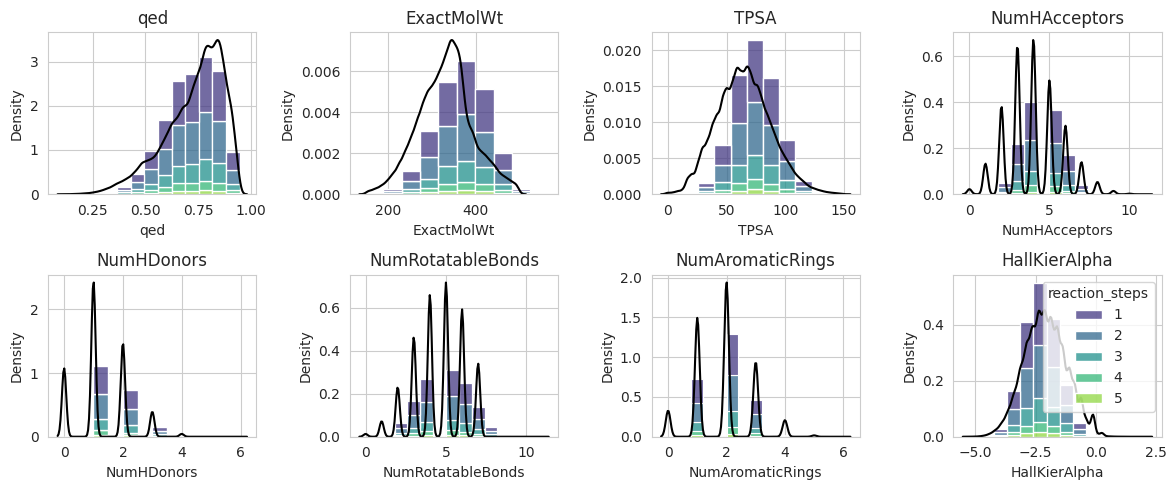

In [14]:
plot_descriptor_distributions(df_descriptors_step, df_zinc)

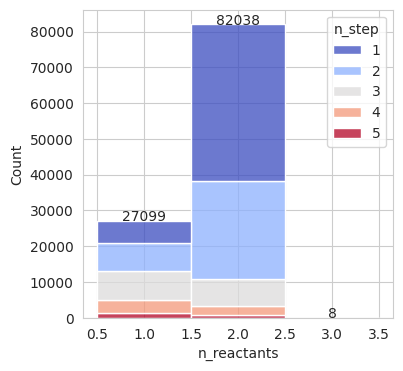

In [15]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

sns.histplot(df_per_step, x="n_reactants", hue="n_step", multiple="stack", palette="coolwarm")
groupby = df_per_step.groupby(["n_reactants"]).size()

for k in df_per_step.n_reactants.unique():
    ax.annotate(
        f"{groupby.loc[k]}",
        xy=(k, groupby.loc[k]),          # target (bar)
        xycoords='data',
        ha='center'
    )

In [ ]:
map_smarts_to_id = {smarts: idx for idx, smarts in enumerate(df_per_step.groupby("or_smarts").size().sort_values(ascending=False).index.tolist())}
df_per_step["smarts_id"] = pd.Categorical(df_per_step["or_smarts"].map(map_smarts_to_id), ordered=True)

In [ ]:
def smarts_to_image(smarts):
    rxn = AllChem.ReactionFromSmarts(smarts)
    img = AllChem.Draw.ReactionToImage(rxn, subImgSize=(300,300))
    return img

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))

sns.histplot(df_per_step, x="smarts_id", hue="n_step", multiple="stack",
             palette="coolwarm_r", ax=ax)

ax.grid(False)
ax.set_xlabel("Reaction SMARTS (sorted by frequency)")
ax.set_ylabel("Count")
ax.set_xticks([])  # Hide x-axis ticks for clarity

plot_inf = [ # (x, y, zoom)
    (0.19, 0.67, 0.2),
    (0.22, 0.55, 0.17),
    (0.3, 0.35, 0.2),
    (0.5, 0.2, 0.2)
]

for smarts_id, (image_xaxis, image_yaxis, zoom) in zip([0, 5, 22, 50], plot_inf):
    smarts = list(map_smarts_to_id.keys())[smarts_id]
    img = smarts_to_image(smarts)

    # Create inset axes for the SMARTS image
    ax_image = fig.add_axes([image_xaxis, image_yaxis, zoom, zoom])
    ax_image.imshow(img)
    ax_image.axis('off')

    # Compute approximate histogram height for arrow target
    count = df_per_step[df_per_step.smarts_id == smarts_id].shape[0]
    arr_mult = 1 if smarts_id != 0 else 0.8

    # Add a *curved* arrow connecting the image and the histogram bar
    ax.annotate(
        '',
        xy=(smarts_id-0.5, arr_mult * count),          # target (bar)
        xycoords='data',
        xytext=(image_xaxis- zoom*0.1, image_yaxis + zoom/4),  # start (center of image)
        textcoords='figure fraction',
        arrowprops=dict(
            arrowstyle="->",
            color='black',
            lw=1.,
            shrinkA=5,
            shrinkB=5,
            connectionstyle="arc3,rad=0.4"  # <--- makes it curved
        )
    )

fig.savefig(os.path.join(FIG_PATH, "smarts_histogram_with_images.pdf"), bbox_inches='tight')


In [ ]:
from rdkit import Chem
from rdkit import DataStructs

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform


df_simi = {
    "n_steps": [],
    "similarity": [],
    "quantile": []
}
QUANTILES = [10**-i for i in np.linspace(1., 4, 100)]

def agg_tanimoto_sim(sub_df):
    """ Get the average tanimoto similarity between all products in the sub_df"""
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=1024) for smi in sub_df.products]
    n = len(fps)
    if n <=1:
        return 1.0
    sims = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            sims[i,j] = sim
            sims[j,i] = sim
    return [np.quantile(sims, 1-q, axis=1) for q in QUANTILES]


for n_steps in tqdm(df_per_step.n_step.unique()):
    sims = agg_tanimoto_sim(df_per_step[df_per_step.n_step==n_steps].sample(1000))
    for i_q, q in enumerate(QUANTILES):
        quantile_sim = sims[i_q]
        for i in range(len(quantile_sim)):
            df_simi["n_steps"].append(n_steps)
            df_simi["similarity"].append(quantile_sim[i])
            df_simi["quantile"].append(q)

df_simi = pd.DataFrame(df_simi)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(df_simi, x="quantile", y="similarity", hue="n_steps", palette="viridis",ax=ax)
ax.set_xlim(10**-4,0.1)
ax.set_xscale("log")
ax.set_xlabel("top-% of most similar molecules")
ax.set_ylabel("Tanimoto similarity\nbetween products")

fig.savefig(os.path.join(FIG_PATH,"tanimoto_similarity_per_reaction_step.pdf"), bbox_inches='tight')

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image, ImageDraw, ImageFont

def plot_mol_high(mol, size, high, bond_high, rgba, width):
    drawer = rdMolDraw2D.MolDraw2DCairo(*size)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=width
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=high,  highlightBonds=bond_high)
    bio = io.BytesIO(drawer.GetDrawingText())
    return Image.open(bio)

def reactions_to_image(smarts, reactants, size=(300, 300), rgba_color= (0.0,0.0,1.0,0.1), rgba_color_prod= (1.0,0.0,0.0,0.1), highlight_width=20):
    # Convert reactants to RDKit molecule objects
    reactant_mols = []
    for r in reactants:
        mol = Chem.MolFromSmiles(r, sanitize=True) if isinstance(r, str) else r
        reactant_mols.append(mol)

    # Create a reaction object from the SMARTS pattern
    rxn = AllChem.ReactionFromSmarts(smarts)
    rxn.Initialize()
    print(rxn.GetNumReactantTemplates())
    # Predict the products using the actual reactants
    products = rxn.RunReactants(reactant_mols)
    # Create a new reaction object with the actual reactants and predicted products

    reactant_highlights = []
    reactant_bond_highlights = []
    for mol, substructure in zip(reactant_mols, rxn.GetReactants()):
        # mol.GetImplicitValence()
        match = mol.GetSubstructMatches(substructure)
        reactant_bond_highlights.append([])
        for bond in mol.GetBonds():
            aid1 = bond.GetBeginAtomIdx()
            aid2 = bond.GetEndAtomIdx()
            if aid1 in match[0] and aid2 in match[0]:
                reactant_bond_highlights[-1].append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        reactant_highlights.append(match)
    products_highlights = []

    product = products[0][0]
    substructure = rxn.GetProducts()[0]

    match = product.GetSubstructMatches(substructure)
    products_highlights.append(match[0])
    product_bond_highlights =[]
    for bond in product.GetBonds():
        aid1 = bond.GetBeginAtomIdx()
        aid2 = bond.GetEndAtomIdx()
        if aid1 in match[0] and aid2 in match[0]:
            product_bond_highlights.append(product.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    reactants_image = []
    for mol, high, bonds in zip(reactant_mols, reactant_highlights, reactant_bond_highlights):
        reactants_image.append(plot_mol_high(mol, size, high[0], bonds, rgba_color, highlight_width))

    prod_img = plot_mol_high(products[0][0], size, products_highlights[0], product_bond_highlights, rgba_color_prod, highlight_width)

    return reactants_image, prod_img

def pil_to_array(img, pad = 0.2):
    if not isinstance(img, Image.Image):
        arr= np.asarray(Image.open(io.BytesIO(img.data)))
    else:
        if img.mode != 'RGB':
            img.load()
            new_img = Image.new("RGB", img.size, (255,255,255))
            new_img.paste(img, mask=img.split()[3])
            arr =  np.asarray(new_img)
        else:
            arr = np.asarray(img)
    idx_non_w = np.where(~(arr.sum(-1) == 255 *3).all(0))[0]
    x_min, x_max = min(idx_non_w), max(idx_non_w)
    arr = arr[:,x_min:x_max,:]
    # Pad
    pad_size = int((x_max - x_min) * pad)
    arr = np.concatenate([255*np.ones_like(arr)[:,:pad_size], arr, 255 *np.ones_like(arr)[:,:pad_size]], axis=1)

    return arr

def text_image(text, height):
    """Create a small image with a centered text like '+' or '→'."""
    W, H = int(height * 0.3), height
    img = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", int(height*10))
    except:
        font = ImageFont.load_default()

    # Use textbbox to get the bounding box of the text
    bbox = draw.textbbox((0, 0), text, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

    draw.text(((W - w)//2, (H - h)//2), text, fill="black", font=font)
    return img


def pad_image_to_height(img_array, target_height):
    """
    Pad a NumPy image array vertically to match target_height.
    Assumes img_array is a 2D or 3D NumPy array (e.g., grayscale or RGB).
    """
    current_height, current_width = img_array.shape[:2]
    if current_height >= target_height:
        return img_array  # No padding needed
    # Calculate padding
    pad_top = (target_height - current_height) // 2
    pad_bottom = target_height - current_height - pad_top
    # Pad the image
    padded_img = np.pad(
        img_array,
        ((pad_top, pad_bottom), (0, 0), (0, 0)),
        mode='constant',
        constant_values=255  # White padding
    )

    return padded_img


def draw_reaction_on_ax(ax, reactant_imgs, product_img, pad_size = 0.2, height = 300, link_zooms = [0.5,0.1]):
    """
    reactant_imgs: list of PIL images
    product_img: PIL image
    """

    # Convert images to arrays
    link_img = [Image.open("notebooks/plus.png"), Image.open("notebooks/arrow.png")]
    link_img_array = []
    for zoom, img in zip(link_zooms,link_img):
        ratio = height / img.height * zoom
        new_width = int(img.width * ratio)
        new_height = int(img.height * ratio)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)
        img_array = pad_image_to_height(pil_to_array(img_resized), height)
        link_img_array.append(img_array)

    arrays = []
    for i,img in enumerate(reactant_imgs):
        arrays.append(pil_to_array(img, pad_size))
        arrays.append(link_img_array[int(i == len(reactant_imgs) - 1)])
    arrays.append(pil_to_array(product_img,pad_size))

    full = np.concatenate(arrays, axis=1)

    # Display
    ax.imshow(full)
    ax.axis("off")



In [ ]:
errs = []

In [ ]:
n_rxns = len(map_smarts_to_id) - len(errs)
reactants = df_per_step[~df_per_step.impossible].groupby("or_smarts")["reactants"].apply(lambda x: np.random.choice(x))

n_cols = 5
fig, axes = plt.subplots(n_rxns // n_cols+1, n_cols, figsize=(8*n_cols,4*n_rxns // n_cols))
axes = axes.flatten()
i_curr = 0
for i,rxn in enumerate(map_smarts_to_id):
    if i in errs:
        continue
    failed = 0
    for _ in range(30):
        try:
            reactant_imgs, product_img = reactions_to_image(
                rxn,
                [Chem.MolFromSmiles(r) for r in reactants.loc[rxn]],
                size=(500, 500),
                highlight_width=10,
                rgba_color=(1.0,0.0,1.0,0.7),
                rgba_color_prod=(1.0,0.5,0.5,0.7),
            )
            draw_reaction_on_ax(axes[i_curr], reactant_imgs, product_img, pad_size=0.1, height=500)
            i_curr += 1
            break
        except Exception as e:
            print(e)
            reactants = df_per_step[~df_per_step.impossible].groupby("or_smarts")["reactants"].apply(lambda x: np.random.choice(x))
            failed += 1

        if failed == 10:
            errs.append(i)

for i in range(i_curr, len(axes)):
    axes[i].axis("off")

fig.tight_layout()
fig.savefig(f"{FIG_PATH}/reaction_dataset.pdf", bbox_inches="tight")

In [ ]:
row_retro = df[(df.reaction_steps == 4) & (df["type of objective"] == "full synthesis")].sample(1)

full_synth = row_retro.full_reaction.iloc[0]

reactants = row_retro.all_reactants.iloc[0]
smarts = row_retro.or_smarts.iloc[0]
row_retro

In [ ]:
reactants

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10,40))
axes = axes.flatten()


i_curr = 0
for rxn, reac in zip(smarts, reactants):
    reactant_imgs, product_img = reactions_to_image(
        rxn,
        [Chem.MolFromSmiles(r) for r in reac],
        size=(500, 500),
        highlight_width=10,
        rgba_color=(1.0,0.0,1.0,0.7),
        rgba_color_prod=(1.0,0.5,0.5,0.7),
    )
    draw_reaction_on_ax(axes[i_curr], reactant_imgs, product_img, pad_size=0.1, height=500)
    i_curr += 1


fig.savefig(f"{FIG_PATH}/retro_synth_ex.pdf", bbox_inches="tight")

In [ ]:
reactants